DE group  1817
ST group  186
3.2211004485421146e-08
DE group  1817
ST group  186


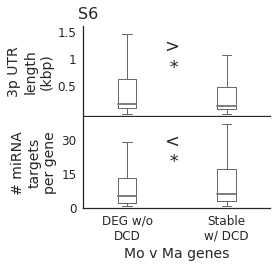

In [6]:
%matplotlib inline

import os as os
import csv as csv
import collections as collect
import operator as op
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
from scipy.stats import mannwhitneyu as mwu
import sklearn as skl
import sklearn.metrics as sklm
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot scatter for mean absolute
# difference in TPM for DE genes
# relative to fc

date = '20180729'

run_mirna_genes = True

save_figures = True
diss_version = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

agg_tpm_file = os.path.join(fhgfs_base, 'salmon', 'deep', 'agg_gene_tpm.h5')
utr_len_file = os.path.join(fhgfs_base, 'references', '20180727_BioMart_ENSv78_UTRs.h5')
tscan_file = os.path.join(fhgfs_base, 'references', 'TargetScan_v7.2_default.h5')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'


def add_diff_tpm_info(s1, s2, data, degenes):
    
    with pd.HDFStore(agg_tpm_file, 'r') as hdf:
        s1_exp = hdf['gene_tpm/' + s1]
        s2_exp = hdf['gene_tpm/' + s2]
        s1_exp[s1] = s1_exp.mean(axis=1)
        s2_exp[s2] = s2_exp.mean(axis=1)
        joined = pd.concat([s1_exp, s2_exp], ignore_index=False,
                           axis=1, sort=True)
        joined['mean_diff'] = (joined[s1] - joined[s2]).abs()
        joined = joined.loc[joined.index.isin(degenes), ['mean_diff']]
        
    data = pd.concat([data, joined], axis=1,
                     ignore_index=False, sort=True)
    assert not pd.isnull(data).any().any(), 'Missing data'
    return data


def build_star_list(pv):
    
    pv_limits = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
    label = ''
    for lim in pv_limits:
        if pv < lim:
            label += '* '
        else:
            break
    if not label:
        label = 'n.s.'
    return label.strip()


def plot_joined_comparisons(data, s1, s2, fk):
    
    num_rows = 2
    num_cols = 1
    fig, axes = plt.subplots(figsize=fig_sizes['one_col']['square'],
                             nrows=num_rows, ncols=num_cols,
                             sharex=True, sharey=False,
                             gridspec_kw={'height_ratios': [1, 1]})
    
    plt.subplots_adjust(hspace=0.01)
    
    xlabel = 'DEGs ({} v {}) w/ and w/o DCD overlap'.format(s1, s2)
    
    ax_utr_len = axes[0]
    tpm_diff_ylabel = 'Mean difference in\nexpression abs(TPM)'
    ax_utr_len = plot_utr_lengths(data, s1, s2, ax_utr_len,  fk)
    
    ax_mirna_trg = axes[1]
    tpm_min_ylabel = 'Min expression (TPM)'
    ax_mirna_trg = plot_mirna_targets(data, s1, s2, ax_mirna_trg, '')
        
    return fig, []


def plot_tpm_boxes(data, xlabel, ylabel, val_type, ax, pk):
    
    ylim_lut = {'mean_diff': (-5, 170),
                'min_tpm': (-0.25, 16),
                'max_tpm': (-5, 250)}
    ytick_lut = {'mean_diff': [50, 100, 150],
                 'min_tpm': [5, 10, 15],
                 'max_tpm': [50, 100, 150, 200]}
    hlines_lut = {'mean_diff': ([140, 155], [[2, 3], [1, 3]]),
                  'min_tpm': ([13, 14.5], [[2, 3], [1, 3]]),
                  'max_tpm': ([220, 240], [[2, 3], [1, 3]])}
    
    boxcolor = 'dimgrey'
    medcolor = 'grey'
    median_props = {'color': medcolor, 'linewidth': 2}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
    
    b, e, n = select_plot_groups(data)
    # body hit
    b = data.loc[b, val_type].values
    # enhancer hit
    e = data.loc[e, val_type].values
    # no hit
    n = data.loc[n, val_type].values
        
    boxes = ax.boxplot([b, e, n], sym="", labels=None,
                       medianprops=median_props, boxprops=box_props,
                       whiskerprops=whisker_props, capprops=cap_props)
        
    y_limits = ylim_lut[val_type]
    ax.set_ylim(*y_limits)
    y_ticks = ytick_lut[val_type]
    
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(map(str, y_ticks), fontsize=12)
    
    hl_y, hl_x = hlines_lut[val_type]
    for hy, hx, (p1, p2) in zip(hl_y, hl_x, [(e, n), (b, n)]):
        pv = mwu(p1, p2, alternative='greater')[1]
        pv_lab = build_star_list(pv)
        if pv_lab != 'n.s.':
            if len(pv_lab) == 5 and (hx[1] - hx[0]) == 2:
                offset = 0.4
            elif len(pv_lab) == 5:
                offset = 0.
            else:
                offset = 0.2
            ax.hlines(hy, hx[0], hx[1])
            ax.text(hx[0] + offset, hy,
                    pv_lab, fontdict={'fontsize': 14})
        else:
            ax.hlines(hy, hx[0], hx[1])
            ax.text(hx[0] + 0.6, hy + 0.5,
                    pv_lab, fontdict={'fontsize': 14})
            
        
    ax.set_xticklabels(['Gene', 'Enh.', 'No ovl.'],
                       fontsize=12, rotation=90)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=14)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    tt = ax.set_title(pk, fontsize=16)
    tt.set_position((0.05, 1.01))
            
    return ax 
    
    
def plot_utr_lengths(data, s1, s2, ax, pk):
    
    feat = '3p_utr_length'
    
    de, st = select_plot_groups(data)
    with pd.HDFStore(utr_len_file, 'r') as hdf:
        utr = hdf['/Ensembl_v78/utr']
        de_utr = utr.loc[utr['name'].isin(de), [feat]]
        de = de_utr.loc[de_utr[feat] > 0, feat]
                
        st_utr = utr.loc[utr['name'].isin(st), [feat]]
        st = st_utr.loc[st_utr[feat] > 0, feat]
        
    boxcolor = 'dimgrey'
    medcolor = 'grey'
    median_props = {'color': medcolor, 'linewidth': 2}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
            
    boxes = ax.boxplot([de, st], sym="", labels=None, positions=[1.1, 1.9],
                       medianprops=median_props, boxprops=box_props,
                       whiskerprops=whisker_props, capprops=cap_props)
        
    pv = mwu(de, st, alternative='greater')[1]
    print(pv)
    
    ax.set_ylim(-50, 1600)
    ax.set_ylabel('3p UTR\nlength\n(kbp)', fontsize=14)
    ax.set_yticks([500, 1000, 1500])
    ax.set_yticklabels(['0.5', '1', '1.5'], fontsize=12)
            
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.text(1.4, 750, '>\n *', fontdict={'fontsize': 18})
    
    tt = ax.set_title(pk, fontsize=16)
    tt.set_position((0.025, 1.01))
            
    return ax


def plot_mirna_targets(data, s1, s2, ax, pk):
    
    de, st = select_plot_groups(data)
    with pd.HDFStore(tscan_file, 'r') as hdf:
        tscan = hdf['targetscan_v72/default']
                
        de = tscan.loc[tscan['name'].isin(de), ['name', 'miR_family']]                
        st = tscan.loc[tscan['name'].isin(st), ['name', 'miR_family']]
        
        de_count = collect.Counter(de['name'])
        de_count = collect.Counter(de_count.values())
        de = np.concatenate([[k] * n for k, n in de_count.items()])
        
        st_count = collect.Counter(st['name'])
        st_count = collect.Counter(st_count.values())
        st = np.concatenate([[k] * n for k, n in st_count.items()])
    
    boxcolor = 'dimgrey'
    medcolor = 'grey'
    median_props = {'color': medcolor, 'linewidth': 2}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
            
    boxes = ax.boxplot([de, st], sym="", labels=None, positions=[1.1, 1.9],
                       medianprops=median_props, boxprops=box_props,
                       whiskerprops=whisker_props, capprops=cap_props)
        
    pv = mwu(de, st, alternative='less')[1]
    
    assert 0.01 < pv < 0.05, 'miRNA pv changed'
        
    ax.set_ylim(0, 40)
    ax.set_yticks([0, 15, 30])
    ax.set_yticklabels(['0', '15', '30'], fontsize=12)
    ax.set_ylabel('# miRNA\ntargets\nper gene', fontsize=14)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.text(1.4, 18, '<\n *', fontdict={'fontsize': 18})
    ax.set_xlim(0.75, 2.25)
    
    ax.set_xticklabels(['DEG w/o\nDCD', 'Stable\nw/ DCD'], fontsize=12)
    ax.set_xlabel('{} v {} genes'.format(s1, s2), fontsize=14)
            
    return ax


def select_plot_groups(data):
    
    select1 = np.logical_and(data['body_hit'] == 0, data['prom_hit'] == 0)
    select2 = np.logical_and(data['total_hits'] == 0, data['is_de'] == 1)
    select = np.logical_and(select1, select2)
    de_group = data.loc[select, :].index
    
    select1 = np.logical_and(data['body_hit'] > 0, data['prom_hit'] == 0)
    select2 = np.logical_and(data['total_hits'] == 0, data['is_de'] < 1)
    select = np.logical_and(select1, select2)
    st_group = data.loc[select, :].index
    
    print('DE group ', de_group.size)
    print('ST group ', st_group.size)
        
    return de_group, st_group


def plot_mirna_regulation():
    # use cached data from other notebooks
    hsp_ovl_cache = os.path.join(cache_dir, '{}_plot_gene-enh-hsp_tpm-bin.h5'.format(date))
    if not os.path.isfile(hsp_ovl_cache):
        raise RuntimeError('No cached data for HSP overlaps')
        
    for seg in segmentations:
        if seg != 'cmm18':
            continue
        for score in scorings:
            if score != 'penem':
                continue
            sciddo_data = dict()
            with pd.HDFStore(hsp_ovl_cache, 'r') as hdf:
                load_keys = sorted([k for k in hdf.keys() if seg in k and score in k])
                for k in load_keys:
                    comp = os.path.split(k)[-1]
                    if comp != 'Mo_vs_Ma':
                        continue
                    s1, s2 = comp.split('_vs_')
                    data = hdf[k]
                    data = add_diff_tpm_info(s1, s2, data, set(data.index))
                    
                    fk = 'S6'
                    fig, exart = plot_joined_comparisons(data, s1, s2, fk)
                    if save_figures:
                        outname = 'fig_{}_hsp_mirna-genes_{}_{}_{}'.format(fk, seg, score, comp)
                        out_folder = fig_supp
                        if diss_version:
                            out_folder = fig_diss

                        out_pdf = os.path.join(out_folder, outname + '.pdf')
                        fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
    
                        if not diss_version:
                            out_png = os.path.join(out_folder, outname + '.png')
                            fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])                
    return



if run_mirna_genes:
    plot_mirna_regulation()
